# GitHub Pull Requests: EDA Notebook

This notebook shows how to:
1. Load raw GitHub PR JSON data.
2. Flatten the nested data structure into a Pandas DataFrame.
3. Subset columns to keep only those we care about.
4. Perform basic exploratory data analysis (EDA).

---

## 1. Setup & Imports

I begin by importing our required libraries:

In [22]:
import pandas as pd
import json

## 2. Load & Flatten the PR JSON Data

I already have a file named `github_prs_raw.json` inside the `../data/` folder. Let's open it, parse the JSON, and create a DataFrame using `pd.json_normalize`.


In [23]:
# Open the raw PR data from a JSON file
with open("../data/github_prs_raw.json", "r") as f:
    raw_pr_data = json.load(f)

# Flatten the nested JSON structure
df_all = pd.json_normalize(raw_pr_data)

# Let's see how many columns we have and show a preview
print(f"Total columns: {df_all.shape[1]}")
df_all.head()  # Just show the head


Total columns: 305


,url,id,node_id,html_url,diff_url,patch_url,issue_url,number,state,locked,...,base.repo.watchers,base.repo.default_branch,_links.self.href,_links.html.href,_links.issue.href,_links.comments.href,_links.review_comments.href,_links.review_comment.href,_links.commits.href,_links.statuses.href
0,https://api.github.com/repos/facebook/react/pu...,2437047584,PR_kwDOAJy2Ks6RQmUg,https://github.com/facebook/react/pull/32812,https://github.com/facebook/react/pull/32812.diff,https://github.com/facebook/react/pull/32812.p...,https://api.github.com/repos/facebook/react/is...,32812,closed,False,...,234089,main,https://api.github.com/repos/facebook/react/pu...,https://github.com/facebook/react/pull/32812,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/st...
1,https://api.github.com/repos/facebook/react/pu...,2434951599,PR_kwDOAJy2Ks6RImmv,https://github.com/facebook/react/pull/32808,https://github.com/facebook/react/pull/32808.diff,https://github.com/facebook/react/pull/32808.p...,https://api.github.com/repos/facebook/react/is...,32808,closed,False,...,234089,main,https://api.github.com/repos/facebook/react/pu...,https://github.com/facebook/react/pull/32808,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/st...
2,https://api.github.com/repos/facebook/react/pu...,2434825260,PR_kwDOAJy2Ks6RIHws,https://github.com/facebook/react/pull/32807,https://github.com/facebook/react/pull/32807.diff,https://github.com/facebook/react/pull/32807.p...,https://api.github.com/repos/facebook/react/is...,32807,closed,False,...,234089,main,https://api.github.com/repos/facebook/react/pu...,https://github.com/facebook/react/pull/32807,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/st...
3,https://api.github.com/repos/facebook/react/pu...,2433093461,PR_kwDOAJy2Ks6RBg9V,https://github.com/facebook/react/pull/32803,https://github.com/facebook/react/pull/32803.diff,https://github.com/facebook/react/pull/32803.p...,https://api.github.com/repos/facebook/react/is...,32803,closed,False,...,234089,main,https://api.github.com/repos/facebook/react/pu...,https://github.com/facebook/react/pull/32803,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/st...
4,https://api.github.com/repos/facebook/react/pu...,2433039137,PR_kwDOAJy2Ks6RBTsh,https://github.com/facebook/react/pull/32802,https://github.com/facebook/react/pull/32802.diff,https://github.com/facebook/react/pull/32802.p...,https://api.github.com/repos/facebook/react/is...,32802,closed,False,...,234089,main,https://api.github.com/repos/facebook/react/pu...,https://github.com/facebook/react/pull/32802,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/is...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/pu...,https://api.github.com/repos/facebook/react/st...


## 3. Inspect All Column Names

I'll list out all the flattened columns to decide which ones are relevant for my analysis.

In [24]:
all_columns = df_all.columns.tolist()
print(all_columns)

['url', 'id', 'node_id', 'html_url', 'diff_url', 'patch_url', 'issue_url', 'number', 'state', 'locked', 'title', 'body', 'created_at', 'updated_at', 'closed_at', 'merged_at', 'merge_commit_sha', 'assignee', 'assignees', 'requested_reviewers', 'requested_teams', 'labels', 'milestone', 'draft', 'commits_url', 'review_comments_url', 'review_comment_url', 'comments_url', 'statuses_url', 'author_association', 'auto_merge', 'active_lock_reason', 'user.login', 'user.id', 'user.node_id', 'user.avatar_url', 'user.gravatar_id', 'user.url', 'user.html_url', 'user.followers_url', 'user.following_url', 'user.gists_url', 'user.starred_url', 'user.subscriptions_url', 'user.organizations_url', 'user.repos_url', 'user.events_url', 'user.received_events_url', 'user.type', 'user.user_view_type', 'user.site_admin', 'head.label', 'head.ref', 'head.sha', 'head.user.login', 'head.user.id', 'head.user.node_id', 'head.user.avatar_url', 'head.user.gravatar_id', 'head.user.url', 'head.user.html_url', 'head.user.

### Observing the Columns

Here, I can see columns like `number`, `state`, `title`, `body`, `merged_at`, etc.  
For a simpler EDA, let's select a small set of columns.

---

## 4. Select Key Columns

I'll define a list of columns that are present and relevant (based on our earlier inspection). I then create a smaller DataFrame `df` with just those columns.


In [25]:
# Pick columns you actually have in df_all
selected_columns = [
    "number",        # PR number
    "state",         # open/closed
    "title",         # PR title
    "body",          # PR description
    "created_at",    # Creation timestamp
    "updated_at",    # Last updated timestamp
    "closed_at",     # If closed
    "merged_at",     # If merged
    "assignee",      # Single assignee (nullable)
    "assignees",     # List of assigned users
    "labels",        # Label objects
    "user.login"     # Author's username
]

# Ensure we only include columns that exist
existing_cols = [col for col in selected_columns if col in df_all.columns]

df = df_all[existing_cols].copy()

print(f"Columns in df: {df.columns.tolist()}")
df.head()


Columns in df: ['number', 'state', 'title', 'body', 'created_at', 'updated_at', 'closed_at', 'merged_at', 'assignee', 'assignees', 'labels', 'user.login']


,number,state,title,body,created_at,updated_at,closed_at,merged_at,assignee,assignees,labels,user.login
0,32812,closed,[DevTools] Release and aquire host instances w...,In persistent mode they can change when they'r...,2025-04-03T13:26:30Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,None,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
1,32808,closed,Minor Tweak to Performance Track,"Rename ""Suspended"" commit to ""Suspended on CSS...",2025-04-02T18:31:06Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,None,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
2,32807,closed,Delete CHANGELOG-canary.md,This is no longer being used or updated\r\n,2025-04-02T17:25:37Z,2025-04-02T20:05:46Z,2025-04-02T20:05:43Z,2025-04-02T20:05:43Z,None,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",mattcarrollcode
3,32803,closed,Follow through all the phases when an error ha...,This can happen for example if you have duplic...,2025-04-02T04:17:40Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,None,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
4,32802,closed,Update CONTRIBUTING.md,<!--\r\n Thanks for submitting a pull request...,2025-04-02T03:18:42Z,2025-04-02T03:19:49Z,2025-04-02T03:19:36Z,None,None,[],[],sjhcursor100


## 5. Visualize Missing Data

Certain columns (like `assignee` or `assignees`) might be empty or `None` across most rows. Let's plot a heatmap of missing values for a subset of the columns (e.g., the first 50) to see the overall pattern.


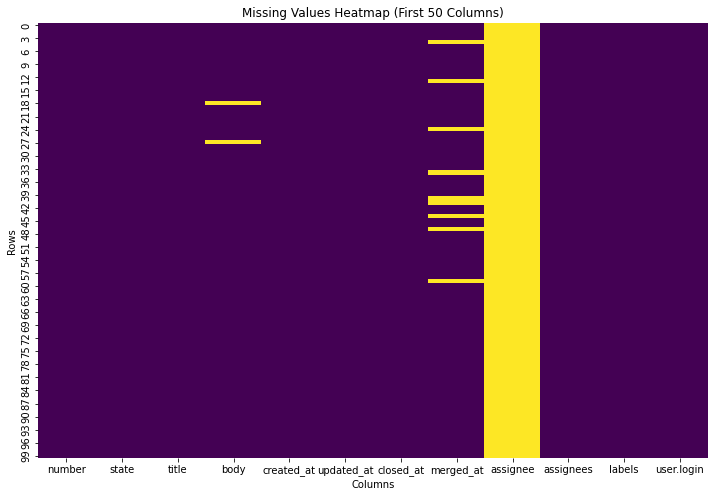

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
plt.figure(figsize=(12, 8))

# We'll just take the first 50 columns to avoid crowding
subset = df.iloc[:, :50]

sns.heatmap(subset.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (First 50 Columns)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


## 6. Drop Columns with Excessive Missing Values

From the heatmap, I see `assignee` is nearly always `None`. Let's remove it (and any other columns that meet a certain missing threshold).

In [27]:
# Decide on a threshold; e.g., drop columns missing in over 90% of rows
threshold = 0.8

# Calculate the percentage of NaN in each column
missing_percent = df.isnull().mean()

# Filter columns that exceed our threshold
cols_to_drop = missing_percent[missing_percent > threshold].index
print("Dropping columns:", cols_to_drop.tolist())

# Drop them
df.drop(columns=cols_to_drop, inplace=True)

# Confirm they’re gone
df.head()


Dropping columns: ['assignee']


,number,state,title,body,created_at,updated_at,closed_at,merged_at,assignees,labels,user.login
0,32812,closed,[DevTools] Release and aquire host instances w...,In persistent mode they can change when they'r...,2025-04-03T13:26:30Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
1,32808,closed,Minor Tweak to Performance Track,"Rename ""Suspended"" commit to ""Suspended on CSS...",2025-04-02T18:31:06Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
2,32807,closed,Delete CHANGELOG-canary.md,This is no longer being used or updated\r\n,2025-04-02T17:25:37Z,2025-04-02T20:05:46Z,2025-04-02T20:05:43Z,2025-04-02T20:05:43Z,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",mattcarrollcode
3,32803,closed,Follow through all the phases when an error ha...,This can happen for example if you have duplic...,2025-04-02T04:17:40Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,[],"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
4,32802,closed,Update CONTRIBUTING.md,<!--\r\n Thanks for submitting a pull request...,2025-04-02T03:18:42Z,2025-04-02T03:19:49Z,2025-04-02T03:19:36Z,None,[],[],sjhcursor100


In [28]:
import numpy as np

def empty_list_to_nan(x):
    # If x is a list and it's empty, return NaN;
    # otherwise return x as-is.
    if isinstance(x, list) and len(x) == 0:
        return np.nan
    return x

# Drop the 'assignees' column entirely
df.drop(columns="assignees", inplace=True, errors="ignore")

# Double-check that 'assignees' is gone
print("Columns after drop:", df.columns.tolist())


Columns after drop: ['number', 'state', 'title', 'body', 'created_at', 'updated_at', 'closed_at', 'merged_at', 'labels', 'user.login']


In [29]:
df.head()

,number,state,title,body,created_at,updated_at,closed_at,merged_at,labels,user.login
0,32812,closed,[DevTools] Release and aquire host instances w...,In persistent mode they can change when they'r...,2025-04-03T13:26:30Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,2025-04-03T14:06:04Z,"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
1,32808,closed,Minor Tweak to Performance Track,"Rename ""Suspended"" commit to ""Suspended on CSS...",2025-04-02T18:31:06Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,2025-04-02T21:01:10Z,"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
2,32807,closed,Delete CHANGELOG-canary.md,This is no longer being used or updated\r\n,2025-04-02T17:25:37Z,2025-04-02T20:05:46Z,2025-04-02T20:05:43Z,2025-04-02T20:05:43Z,"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",mattcarrollcode
3,32803,closed,Follow through all the phases when an error ha...,This can happen for example if you have duplic...,2025-04-02T04:17:40Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,2025-04-02T14:49:45Z,"[{'id': 196858374, 'node_id': 'MDU6TGFiZWwxOTY...",sebmarkbage
4,32802,closed,Update CONTRIBUTING.md,<!--\r\n Thanks for submitting a pull request...,2025-04-02T03:18:42Z,2025-04-02T03:19:49Z,2025-04-02T03:19:36Z,None,[],sjhcursor100


## 7. Drop Missing Times

If a pull request is never merged, or if `merged_at` is null, I can't calculate a valid time-to-merge. Let's remove rows where the merge time is missing.


In [30]:
# Convert created_at / merged_at to datetime if not already done
df["created_dt"] = pd.to_datetime(df["created_at"], errors="coerce")
df["merged_dt"] = pd.to_datetime(df["merged_at"], errors="coerce")

# Compute time_to_merge_hours
df["time_to_merge_hours"] = (df["merged_dt"] - df["created_dt"]).dt.total_seconds() / 3600

# Some PRs might never merge; let's drop rows missing this
before_drop = len(df)
df.dropna(subset=["time_to_merge_hours"], inplace=True)
after_drop = len(df)

print(f"Dropped {before_drop - after_drop} rows where 'time_to_merge_hours' was NaN.")
df[["number", "state", "time_to_merge_hours"]].head(100)

Dropped 9 rows where 'time_to_merge_hours' was NaN.


,number,state,time_to_merge_hours
0,32812,closed,0.659444
1,32808,closed,2.501111
2,32807,closed,2.668333
3,32803,closed,10.534722
5,32801,closed,1.161111
...,...,...,...
95,32669,closed,0.337778
96,32668,closed,0.373333
97,32666,closed,12.281944
98,32665,closed,40.954444


In [32]:
# Assume df_final is your cleaned and processed DataFrame in your EDA notebook
df.to_csv("/Users/cememirsenyurt/github-pr-time-estimator/ml/data/processed_pr_data.csv", index=False)
print("Processed data saved to ../data/processed_pr_data.csv")

Processed data saved to ../data/processed_pr_data.csv
